##**Hyperparameters**

target_size=(250, 450) 

batch_size=80

epochs = 40

tf.keras.optimizers.SGD(learning_rate= lr_schedule)

intital_learning_rate = 0.001

x = layers.Dense(1024, activation='relu')(x)   

x = layers.Dense(512, activation='relu')(x)

x = layers.Dense(256, activation='relu')(x)   

x = layers.Dense(128, activation='relu')(x)   

x = layers.Dense(64, activation='relu')(x)                 

x = layers.Dense(32, activation='relu')(x)                 

x = layers.Dense(1)(x) 

x = layers.Activation(tf.nn.sigmoid)(x)




##**Packages**

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import keras
import cv2
import pickle
import sklearn

from sklearn.metrics import auc, f1_score, roc_curve, recall_score, precision_score, accuracy_score, confusion_matrix
from sklearn import metrics
from google.colab import files
from keras.preprocessing import image
from keras.layers.serialization import activation
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet101V2
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K
from tensorflow.keras import layers
from keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
!pip install h5py pyyaml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##**Data directory**

In [ ]:
base_dir = '/content/drive/MyDrive/1wholeDatasetTrain&Test'

training_set_dir = os.path.join(base_dir, 'training_set')
test_set_dir = os.path.join(base_dir, 'test_set')

train_lungCancer_dir = os.path.join(training_set_dir, 'lungCancer') 
train_normal_dir = os.path.join(training_set_dir, 'normal')
test_lungCancer_dir = os.path.join(test_set_dir, 'lungCancer')
test_normal_dir = os.path.join(test_set_dir, 'normal')

In [ ]:
train_lungCancer_names = os.listdir(train_lungCancer_dir)
print(train_lungCancer_names[:10])

train_normal_names = os.listdir(train_normal_dir)
print(train_normal_names[:10])

['Copy of 0000099 (31).tif', 'Copy of 0000099 (32).tif', 'Copy of 0000099 (37).tif', 'Copy of 0001377 (54).tif', 'Copy of 0000099 (30).tif', 'Copy of 0000099 (35).tif', 'Copy of 0000099 (36).tif', 'Copy of 0000099 (29).tif', 'Copy of 0000099 (34).tif', 'Copy of 0000099 (33).tif']
['Copy of 0000003 (10).tif', 'Copy of 0000003 (14).tif', 'Copy of 0000003 (12).tif', 'Copy of 0000003 (15).tif', 'Copy of 0000003 (18).tif', 'Copy of 0000044 (23).tif', 'Copy of 0000003 (17).tif', 'Copy of 0000003 (11).tif', 'Copy of 0000003 (16).tif', 'Copy of 0000003 (13).tif']


In [ ]:
print('total training lungCancer images:', len(os.listdir(train_lungCancer_dir)))
print('total training normal images:', len(os.listdir(train_normal_dir)))

total training lungCancer images: 596
total training normal images: 601


##**Checking Patient overlap**

In [ ]:
train_df = pd.read_csv(r'/content/drive/MyDrive/DatasetLung.csv')

In [ ]:
test_df = pd.read_csv(r'/content/drive/MyDrive/testSetWholeModel.csv')

In [ ]:
train_df.head()

,PatientId,fileName,filePath,Label
0,1,0000001 (1).tif,C:\Users\mkari\Desktop\Normal for model\000000...,normal
1,1,0000001 (2).tif,C:\Users\mkari\Desktop\Normal for model\000000...,normal
2,1,0000001 (3).tif,C:\Users\mkari\Desktop\Normal for model\000000...,normal
3,1,0000001 (4).tif,C:\Users\mkari\Desktop\Normal for model\000000...,normal
4,1,0000001 (5).tif,C:\Users\mkari\Desktop\Normal for model\000000...,normal


In [ ]:
test_df.head()

,PatientId,fileName,filePath,Label
0,149,0000149 (1).tif,C:\Users\mkari\Desktop\wholeModel TestSet\lung...,lungCancer
1,149,0000149 (2).tif,C:\Users\mkari\Desktop\wholeModel TestSet\lung...,lungCancer
2,149,0000149 (3).tif,C:\Users\mkari\Desktop\wholeModel TestSet\lung...,lungCancer
3,149,0000149 (4).tif,C:\Users\mkari\Desktop\wholeModel TestSet\lung...,lungCancer
4,149,0000149 (5).tif,C:\Users\mkari\Desktop\wholeModel TestSet\lung...,lungCancer


In [ ]:
print(train_df.shape)
print(test_df.shape)

(1197, 4)
(298, 4)


In [ ]:
def check_for_leakage(df1, df2, patient_col):
   
    df1_patients_unique = set(df1[patient_col])
    df2_patients_unique = set(df2[patient_col])
    
    patients_in_both_groups = list(df1_patients_unique.intersection(df2_patients_unique))

    leakage = True if len(patients_in_both_groups)>0 else False 
    
    return leakage

In [ ]:
check_for_leakage(train_df, test_df, 'PatientId')

False

In [ ]:
print("leakage between train and valid: {}".format(check_for_leakage(train_df, test_df, 'PatientId')))

leakage between train and valid: False


##**Data visualization**

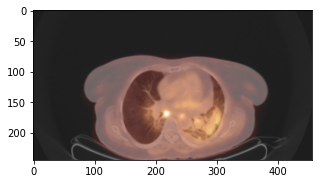

sample PET/CT image name is Copy of 0001377 (51).tif


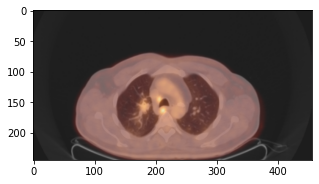

sample PET/CT image name is Copy of 0001044 (49).tif


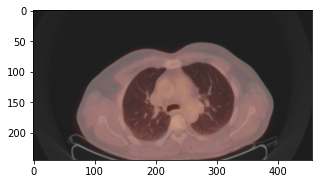

sample PET/CT image name is Copy of 0000012 (7).tif


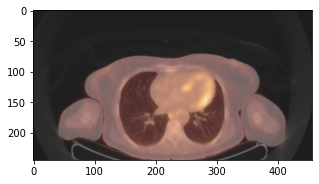

sample PET/CT image name is Copy of 0000007 (44).tif


In [ ]:
import random


images= []

for i in range(2):
  images.append(random.randint(0,500))


for j in images:
  plt.figure(figsize=(5,5))
  plt.imshow(load_img(f"{os.path.join(train_lungCancer_dir, os.listdir(train_lungCancer_dir)[j])}"))
  plt.show()
  print(f'sample PET/CT image name is {os.listdir(train_lungCancer_dir)[j]}')



images= []

for i in range(2):
  images.append(random.randint(0,500))


for j in images:
  plt.figure(figsize=(5,5))
  plt.imshow(load_img(f"{os.path.join(train_normal_dir, os.listdir(train_normal_dir)[j])}"))
  plt.show()
  print(f'sample PET/CT image name is {os.listdir(train_normal_dir)[j]}')

##**Data generation**

In [ ]:
print(training_set_dir)
print(test_set_dir)

/content/drive/MyDrive/1wholeDatasetTrain&Test/training_set
/content/drive/MyDrive/1wholeDatasetTrain&Test/test_set


In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                  rotation_range= 15,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  zoom_range=0.1,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        training_set_dir,  
        target_size=(250, 450),  
        batch_size=80,
        class_mode='binary',
        shuffle = True)


test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_datagen.flow_from_directory(
        test_set_dir,  
        target_size=(250, 450),  
        batch_size=4,
        class_mode='binary')

Found 1197 images belonging to 3 classes.
Found 298 images belonging to 2 classes.


##**defining model**

In [ ]:
pre_trained_model = ResNet101V2(include_top=False, 
                                        weights= 'imagenet',
                                        input_shape = (250, 450, 3))
  
for layer in pre_trained_model.layers:
  layer.trainable = False

171317808/171317808 [==============================] - 1s 0us/step


In [ ]:
pre_trained_model.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 450, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 256, 456, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 125, 225, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                        

In [ ]:
last_layer = pre_trained_model.get_layer('post_relu')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)   
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)   
x = layers.Dense(128, activation='relu')(x)   
x = layers.Dense(64, activation='relu')(x)                 
x = layers.Dense(32, activation='relu')(x)                 
x = layers.Dense(1)(x) 
x = layers.Activation(tf.nn.sigmoid)(x)

model = Model(pre_trained_model.input, x) 

last layer output shape:  (None, 8, 15, 2048)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 450, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 256, 456, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 125, 225, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

##**defining model callbacks**

In [ ]:
checkpoint_path = os.path.join('/content/drive/MyDrive/weights54wholeModel','1')
checkpoint_dir = os.path.dirname(checkpoint_path)
print(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, save_best_only=True, verbose= 1)

/content/drive/MyDrive/weights54wholeModel/1


In [ ]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.7, staircase=True)

##**compiling the model**

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate= lr_schedule), loss= 'binary_crossentropy', metrics= [tf.keras.metrics.BinaryAccuracy(name="Binary_accuracy"),
                        tf.keras.metrics.Precision(name='Precision'),
                        tf.keras.metrics.Recall(name='Recall'), 
                        tf.keras.metrics.TruePositives(name='TP'), 
                        tf.keras.metrics.TrueNegatives(name='TN'), 
                        tf.keras.metrics.FalseNegatives(name='FN'), 
                        tf.keras.metrics.FalsePositives(name='FP'),
                        tf.keras.metrics.AUC(name='AUC')])

In [ ]:
history = model.fit(
            train_generator,
            validation_data = test_generator,
            epochs = 40,
            verbose = 1,
            callbacks = [cp_callback])

Epoch 1/40
15/15 [==============================] - ETA: 0s - loss: 0.6361 - Binary_accuracy: 0.6441 - Precision: 0.6481 - Recall: 0.6373 - TP: 383.0000 - TN: 388.0000 - FN: 218.0000 - FP: 208.0000 - AUC: 0.6964 
Epoch 1: val_loss improved from inf to 0.62547, saving model to /content/drive/MyDrive/weights54wholeModel/1
15/15 [==============================] - 703s 46s/step - loss: 0.6361 - Binary_accuracy: 0.6441 - Precision: 0.6481 - Recall: 0.6373 - TP: 383.0000 - TN: 388.0000 - FN: 218.0000 - FP: 208.0000 - AUC: 0.6964 - val_loss: 0.6255 - val_Binary_accuracy: 0.6309 - val_Precision: 0.5765 - val_Recall: 0.9866 - val_TP: 147.0000 - val_TN: 41.0000 - val_FN: 2.0000 - val_FP: 108.0000 - val_AUC: 0.8318
Epoch 2/40
15/15 [==============================] - ETA: 0s - loss: 0.4814 - Binary_accuracy: 0.7845 - Precision: 0.7798 - Recall: 0.7953 - TP: 478.0000 - TN: 461.0000 - FN: 123.0000 - FP: 135.0000 - AUC: 0.8673
Epoch 2: val_loss improved from 0.62547 to 0.43673, saving model to /conte

##**Downloading history**

In [ ]:
def download_history():
  with open('history_augmented_54wholeModel.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  files.download('history_augmented_54wholeModel.pkl')

download_history()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##**Accuracy and loss plotting**

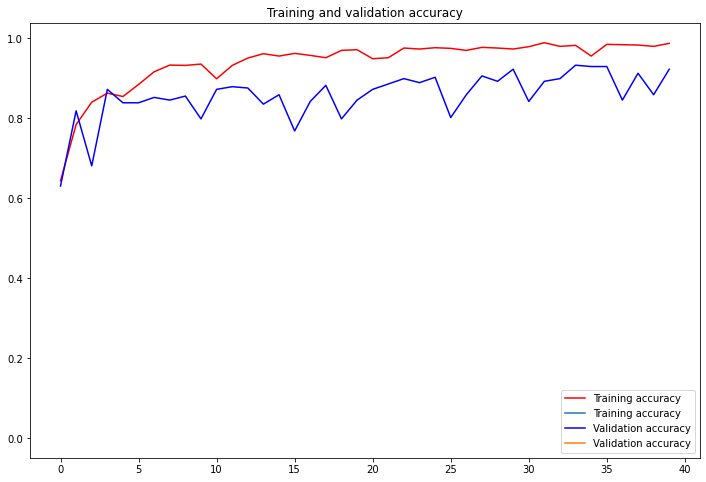

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['Binary_accuracy']
val_acc = history.history['val_Binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12,8))
plt.plot(epochs, acc, 'r', 0.001, label='Training accuracy')
plt.plot(epochs, val_acc, 'b', 0.001, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.show()

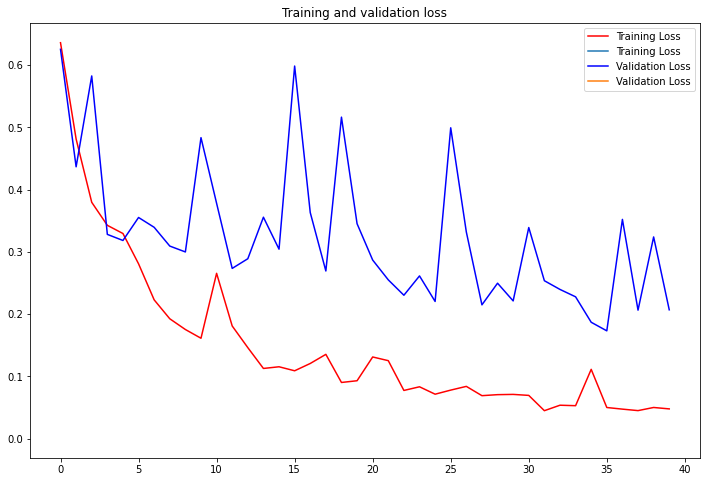

<Figure size 432x288 with 0 Axes>

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))


plt.figure(figsize=(12,8))
plt.plot(epochs, loss, 'r', 0.001, label='Training Loss')
plt.plot(epochs, val_loss, 'b', 0.001, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()


plt.show()

##**Model evaluation**

In [ ]:
model.evaluate(test_generator)

75/75 [==============================] - 5s 62ms/step - loss: 0.2070 - Binary_accuracy: 0.9228 - Precision: 0.9500 - Recall: 0.8926 - TP: 133.0000 - TN: 142.0000 - FN: 16.0000 - FP: 7.0000 - AUC: 0.9810


[0.20700496435165405,
 0.9228187799453735,
 0.949999988079071,
 0.8926174640655518,
 133.0,
 142.0,
 16.0,
 7.0,
 0.9810143113136292]

##**LoadingWeightsofThemodel**

In [ ]:
pre_trained_model = ResNet101V2(include_top=False, 
                                        weights= 'imagenet',
                                        input_shape = (250, 450, 3))
  
for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
last_layer = pre_trained_model.get_layer('post_relu')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)   
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)                 
x = layers.Dense(32, activation='relu')(x)                 
x = layers.Dense(1)(x) 
x = layers.Activation(tf.nn.sigmoid)(x)

model2 = Model(pre_trained_model.input, x) 

last layer output shape:  (None, 8, 15, 2048)


In [ ]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 0.001), loss= 'binary_crossentropy', metrics= [tf.keras.metrics.BinaryAccuracy(name="Binary_accuracy"),
                        tf.keras.metrics.Precision(name='Precision'),
                        tf.keras.metrics.Recall(name='Recall'), 
                        tf.keras.metrics.TruePositives(name='TP'), 
                        tf.keras.metrics.TrueNegatives(name='TN'), 
                        tf.keras.metrics.FalseNegatives(name='FN'), 
                        tf.keras.metrics.FalsePositives(name='FP'),
                        tf.keras.metrics.AUC(name='AUC')])

In [ ]:
model2.load_weights(checkpoint_path)

In [ ]:
model2.evaluate(test_generator)

75/75 [==============================] - 8s 65ms/step - loss: 0.1732 - Binary_accuracy: 0.9295 - Precision: 0.9384 - Recall: 0.9195 - TP: 137.0000 - TN: 140.0000 - FN: 12.0000 - FP: 9.0000 - AUC: 0.9829


[0.1731969267129898,
 0.9295302033424377,
 0.9383561611175537,
 0.9194630980491638,
 137.0,
 140.0,
 12.0,
 9.0,
 0.9829286932945251]

##**Uploading data directly from Drive**

In [ ]:
base_dir = '/content/drive/MyDrive/1wholeDatasetTrain&Test'

training_set_dir = os.path.join(base_dir, 'training_set')
test_set_dir = os.path.join(base_dir, 'test_set')

train_lungCancer_dir = os.path.join(training_set_dir, 'lungCancer') 
train_normal_dir = os.path.join(training_set_dir, 'normal')
test_lungCancer_dir = os.path.join(test_set_dir, 'lungCancer')
test_normal_dir = os.path.join(test_set_dir, 'normal')

print(test_normal_dir)
print(test_lungCancer_dir)

/content/drive/MyDrive/1wholeDatasetTrain&Test/test_set/normal
/content/drive/MyDrive/1wholeDatasetTrain&Test/test_set/lungCancer


##**time calculation**

In [ ]:
%%time
fileNames1 = os.listdir(test_normal_dir)
filePaths1 = []

for i in fileNames1:
  path = '/content/drive/MyDrive/1wholeDatasetTrain&Test/test_set/normal/'
  new_path = path + i
  filePaths1.append(new_path)

my_y_pred1 = []


for fn in filePaths1:

  img = tf.keras.utils.load_img(fn, target_size=(250, 450))
  x = tf.keras.utils.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model2.predict(images, batch_size=10)
  my_y_pred1.append(classes)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " lunCancer does not exist in this slice")
  else:
    print(fn + " lungCancer exists in this slice")



y_pred1 = np.array(my_y_pred1)
y_pred1.resize(1,len(my_y_pred1))
y_pred1






fileNames2 = os.listdir(test_lungCancer_dir)
filePaths2 = []

for i in fileNames2:
  path = '/content/drive/MyDrive/1wholeDatasetTrain&Test/test_set/lungCancer/'
  new_path = path + i
  filePaths2.append(new_path)


my_y_pred2 = []


for fn in filePaths2:

  img = tf.keras.utils.load_img(fn, target_size=(250, 450))
  x = tf.keras.utils.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model2.predict(images, batch_size=10)
  my_y_pred2.append(classes)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " lunCancer does not exist in this slice")
  else:
    print(fn + " lungCancer exists in this slice")



y_pred2 = np.array(my_y_pred2)
y_pred2.resize(1,len(my_y_pred2))
y_pred2
 
 

##**Roc curve**

In [ ]:
y_pred_ResNet101_wholeModel = np.concatenate((y_pred1, y_pred2), axis=None)
print(len(y_pred_ResNet101_wholeModel))

In [ ]:
labels = np.array([1, 1, 1, 1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
               ,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
               0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
               0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
print(len(labels))

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(labels, y_pred_ResNet101_wholeModel, pos_label=1)
auc = metrics.auc(fpr, tpr)

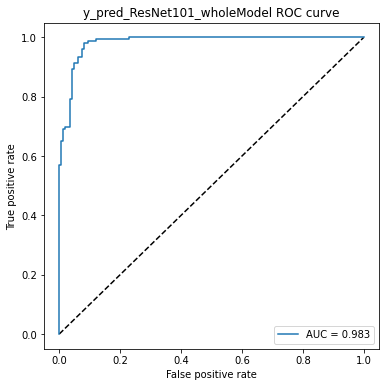

In [ ]:
plt.figure(figsize=(6,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('y_pred_ResNet101_wholeModel ROC curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model2.evaluate(test_generator)

75/75 [==============================] - 5s 66ms/step - loss: 0.1732 - Binary_accuracy: 0.9295 - Precision: 0.9384 - Recall: 0.9195 - TP: 137.0000 - TN: 140.0000 - FN: 12.0000 - FP: 9.0000 - AUC: 0.9829


[0.17319698631763458,
 0.9295302033424377,
 0.9383561611175537,
 0.9194630980491638,
 137.0,
 140.0,
 12.0,
 9.0,
 0.9829286932945251]